In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
import re
from tqdm.contrib.concurrent import process_map
nltk.download('stopwords')
from bs4 import BeautifulSoup
# import spacy
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# mounting google drive to get the sqlite file
from google.colab import drive
drive_path = drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# storing the file path in a variable
file_path = "/content/drive/MyDrive/foods.txt"

# Reading the content of the files using readlines
# readlines reads each line in a iteration
# Storing all the data in the variable file_data
with open(file_path, 'r', encoding='latin-1') as file:
    file_data = file.readlines()

In [4]:
# Creating an empty lists of each column of the our dataframe
productIds, userIds, profileNames, helpfulness, scores, times, summaries, texts = ([] for _ in range(8))

# Going through each line of the data and appending them into different columns (separating the data column wise)
for line in file_data:
    if line.startswith('product/productId:'):
        productIds.append(line.split(': ')[1].strip())
    elif line.startswith('review/userId:'):
        userIds.append(line.split(': ')[1].strip())
    elif line.startswith('review/profileName:'):
        profileNames.append(line.split(': ')[1].strip())
    elif line.startswith('review/helpfulness:'):
        helpfulness.append(line.split(': ')[1].strip())
    elif line.startswith('review/score:'):
        scores.append(line.split(': ')[1].strip())
    elif line.startswith('review/time:'):
        times.append(line.split(': ')[1].strip())
    elif line.startswith('review/summary:'):
        summaries.append(line.split(': ')[1].strip())
    elif line.startswith('review/text:'):
        texts.append(line.split(': ')[1].strip())

# checking if the data split correctly into different columns
print("Sameple data of productIds: ", productIds[:5])
print("Sameple data of userIds: ", userIds[:5])
print("Sameple data of profileNames: ", profileNames[:5])
print("Sameple data of helpfulness: ", helpfulness[:5])
print("Sameple data of scores: ", scores[:5])
print("Sameple data of times: ", times[:5])
print("Sameple data of summaries: ", summaries[:5])
print("Sameple data of texts: ", texts[:2])

Sameple data of productIds:  ['B001E4KFG0', 'B00813GRG4', 'B000LQOCH0', 'B000UA0QIQ', 'B006K2ZZ7K']
Sameple data of userIds:  ['A3SGXH7AUHU8GW', 'A1D87F6ZCVE5NK', 'ABXLMWJIXXAIN', 'A395BORC6FGVXV', 'A1UQRSCLF8GW1T']
Sameple data of profileNames:  ['delmartian', 'dll pa', 'Natalia Corres "Natalia Corres"', 'Karl', 'Michael D. Bigham "M. Wassir"']
Sameple data of helpfulness:  ['1/1', '0/0', '1/1', '3/3', '0/0']
Sameple data of scores:  ['5.0', '1.0', '4.0', '2.0', '5.0']
Sameple data of times:  ['1303862400', '1346976000', '1219017600', '1307923200', '1350777600']
Sameple data of summaries:  ['Good Quality Dog Food', 'Not as Advertised', '"Delight" says it all', 'Cough Medicine', 'Great taffy']
Sameple data of texts:  ['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.', 'Prod

In [5]:
# Creating a data frame with the above column data
foods_df = pd.DataFrame({
    'product/productId': productIds,
    'review/userId': userIds,
    'review/profileName': profileNames,
    'review/helpfulness': helpfulness,
    'review/score': scores,
    'review/time': times,
    'review/summary': summaries,
    'review/text': texts
})
foods_df.head()

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
# converting all the data into lower case
foods_df['review/text'] = foods_df['review/text'].str.lower()
foods_df['review/summary'] = foods_df['review/summary'].str.lower()
foods_df['review/profileName'] = foods_df['review/profileName'].str.lower()

In [7]:
# checking if there is nan data
print(foods_df[foods_df == 'nan'].count())

product/productId      0
review/userId          0
review/profileName    34
review/helpfulness     0
review/score           0
review/time            0
review/summary         2
review/text            0
dtype: int64


In [8]:
# checking if there is none data
print(foods_df[foods_df == 'none'].count())

product/productId      0
review/userId          0
review/profileName    20
review/helpfulness     0
review/score           0
review/time            0
review/summary         2
review/text            0
dtype: int64


In [9]:
# the data which is nan
foods_df[foods_df['review/profileName'] == 'nan']

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
25509,B000LKZB4Y,A36BVYD0NT7Z0F,nan,0/0,5.0,1314576000,these are the best mints and no aspartame or bht,i was so shocked to find out that almost all g...
29042,B000MPRP4C,A1DJV0XTCCSZ8F,nan,0/0,5.0,1342915200,best tea ever,"addicted to this bright, strong tea for breakf..."
38874,B000AYDGZ2,A36BVYD0NT7Z0F,nan,2/3,1.0,1278374400,doesn't anyone care that they are putting bht ...,i called kellogg's to see why special k red be...
49800,B000CRHQN0,A2LYFY32LXQDON,nan,0/0,2.0,1282608000,they were melted and the chocolate had turned ...,we love these bars but i won't order them ship...
67077,B0006348H2,A2P0P67Y55SNOX,nan,1/1,5.0,1314662400,wheatgrass,kitty seems to like this sprinkled on her food...
106550,B001EQ5DG0,A1P500QXEG3IUZ,nan,0/0,5.0,1326758400,finally!,"you cannot find this in the stores anymore, it..."
110490,B00438XVGU,AOISTMMFDR9LU,nan,0/0,5.0,1348012800,very good price,i always like starbucks via ready brew coffee....
113995,B000EYRHL2,AUQ465FVJ8ID8,nan,0/0,5.0,1324166400,"fabulous, nutritious, lightweight, gluten-free!","i am celiac and it is hard to travel, particul..."
137613,B000CQE3HS,AGT3BYX5P9SLH,nan,0/0,5.0,1324684800,awesome,i love them they are amazing i would eat them ...
163191,B000CQID1A,AGT3BYX5P9SLH,nan,0/0,5.0,1324684800,awesome,i love them they are amazing i would eat them ...


In [10]:
foods_df[(foods_df['review/summary'] == 'nan') | (foods_df['review/summary'] == 'none') | (foods_df['review/summary'] == '1') | (foods_df['review/summary'] == 'n/a')]

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
33958,B00412W76S,A3TJPSWY2HE4BS,"s. layton ""homeschool blogger""",1/24,2.0,1173312000,n/a,i only used two maybe three tea bags and got p...
40548,B00020HHRW,A3TJPSWY2HE4BS,"s. layton ""homeschool blogger""",1/24,2.0,1173312000,n/a,i only used two maybe three tea bags and got p...
101106,B0014B0HWK,A3TJPSWY2HE4BS,"s. layton ""homeschool blogger""",1/24,2.0,1173312000,n/a,i only used two maybe three tea bags and got p...
102979,B000FVDWU4,A3TJPSWY2HE4BS,"s. layton ""homeschool blogger""",1/24,2.0,1173312000,n/a,i only used two maybe three tea bags and got p...
117515,B0016B7Z32,A3TJPSWY2HE4BS,"s. layton ""homeschool blogger""",1/24,2.0,1173312000,n/a,i only used two maybe three tea bags and got p...
119242,B000E1DSTK,A2OEAC7J61WO8W,hollis mccollum,0/0,5.0,1310774400,none,this was avaiable at the store. but they quit ...
144396,B001TNXSZG,A3JYBMJJWX5ABL,rbeccaboopsie,3/4,5.0,1333324800,none,i have been drinking mate for years and this i...
155712,B0009VO58S,A3TJPSWY2HE4BS,"s. layton ""homeschool blogger""",1/24,2.0,1173312000,n/a,i only used two maybe three tea bags and got p...
178290,B00073IVAQ,A3TJPSWY2HE4BS,"s. layton ""homeschool blogger""",1/24,2.0,1173312000,n/a,i only used two maybe three tea bags and got p...
198474,B000FVBYCW,A3TJPSWY2HE4BS,"s. layton ""homeschool blogger""",1/24,2.0,1173312000,n/a,i only used two maybe three tea bags and got p...


We can see a lot of data missing in the summaries column but there is an associated text column present. But, if we see the data carefully we observe that there is a lot of duplicate data.

In [11]:
# we replaced all the profile names that were nan with anonymous
foods_df['review/profileName'] = foods_df['review/profileName'].replace('nan', 'anonymous')
print(foods_df[foods_df['review/profileName'] == 'nan'].count())

product/productId     0
review/userId         0
review/profileName    0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64


In [12]:
# we replaced all the summarires that were nan with anonymous
foods_df['review/summary'] = foods_df['review/summary'].replace('nan', 'no summary')
print(foods_df[foods_df['review/summary'] == 'nan'].count())

product/productId     0
review/userId         0
review/profileName    0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64


We can plot to see how many of our reviews are postive(>3), negative(<3) and neutral(=3)

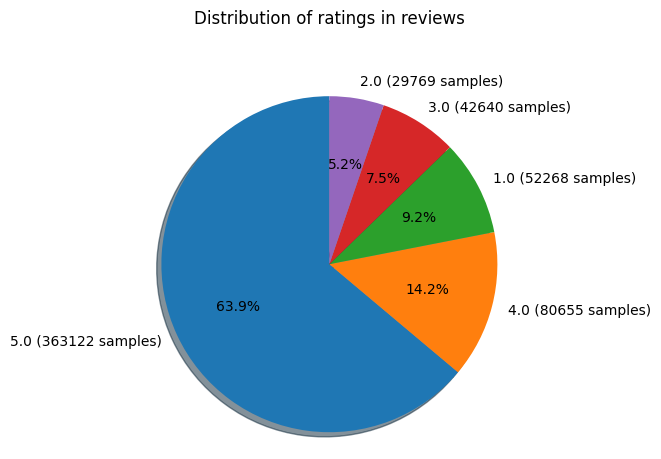

In [13]:
labels = [f'{k} ({foods_df["review/score"].value_counts()[k]} samples)' for k in foods_df['review/score'].value_counts().keys()]
sizes = dict(foods_df['review/score'].value_counts()).values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')
ax1.set_title("Distribution of ratings in reviews",pad=40)
plt.show();

We can see a lot of positive reviews and a very little neutral reviews
1. positive reviews: 78% (approximately)
2. Negative reviews: 14% (approximately)
3. Neutral reviews: 8% (approximately)

In [14]:
# foods_df.dropna(inplace=True)
# foods_df = foods_df.drop_duplicates()
# foods_df

Now since we want to classify if a data is positive or negative we have to decide which scores are positive and negative.
considerations:
1. score = 4, 5 as positive
2. score = 1, 2 as negative
3. score = 3 as neutral
So, we can remove the data with score = 3 to make the data even cleaner

In [15]:
# converting score into float
foods_df['review/score'] = foods_df['review/score'].astype(float)

In [16]:
foods_df = foods_df[foods_df['review/score'] != 3]
foods_df

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,good quality dog food,i have bought several of the vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"natalia corres ""natalia corres""",1/1,4.0,1219017600,"""delight"" says it all",this is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,karl,3/3,2.0,1307923200,cough medicine,if you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"michael d. bigham ""m. wassir""",0/0,5.0,1350777600,great taffy,great taffy at a great price. there was a wid...
...,...,...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,lettie d. carter,0/0,5.0,1299628800,will not do without,great for sesame chicken..this is a good if no...
568450,B003S1WTCU,A3I8AFVPEE8KI5,r. sawyer,0/0,2.0,1331251200,disappointed,i'm disappointed with the flavor. the chocolat...
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2/2,5.0,1329782400,perfect for our maltipoo,"these stars are small, so you can give 10-15 o..."
568452,B004I613EE,A3IBEVCTXKNOH,"kathy a. welch ""katwel""",1/1,5.0,1331596800,favorite training and reward treat,these are the best treats for training and rew...


In [17]:
# Assigning review type based on score
foods_df.loc[foods_df["review/score"] > 3, 'review/type'] = 'Positive'
foods_df.loc[foods_df["review/score"] < 3, 'review/type'] = 'Negative'
foods_df

<ipython-input-17-207736703d4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df.loc[foods_df["review/score"] > 3, 'review/type'] = 'Positive'


,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,good quality dog food,i have bought several of the vitality canned d...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"natalia corres ""natalia corres""",1/1,4.0,1219017600,"""delight"" says it all",this is a confection that has been around a fe...,Positive
3,B000UA0QIQ,A395BORC6FGVXV,karl,3/3,2.0,1307923200,cough medicine,if you are looking for the secret ingredient i...,Negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"michael d. bigham ""m. wassir""",0/0,5.0,1350777600,great taffy,great taffy at a great price. there was a wid...,Positive
...,...,...,...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,lettie d. carter,0/0,5.0,1299628800,will not do without,great for sesame chicken..this is a good if no...,Positive
568450,B003S1WTCU,A3I8AFVPEE8KI5,r. sawyer,0/0,2.0,1331251200,disappointed,i'm disappointed with the flavor. the chocolat...,Negative
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2/2,5.0,1329782400,perfect for our maltipoo,"these stars are small, so you can give 10-15 o...",Positive
568452,B004I613EE,A3IBEVCTXKNOH,"kathy a. welch ""katwel""",1/1,5.0,1331596800,favorite training and reward treat,these are the best treats for training and rew...,Positive


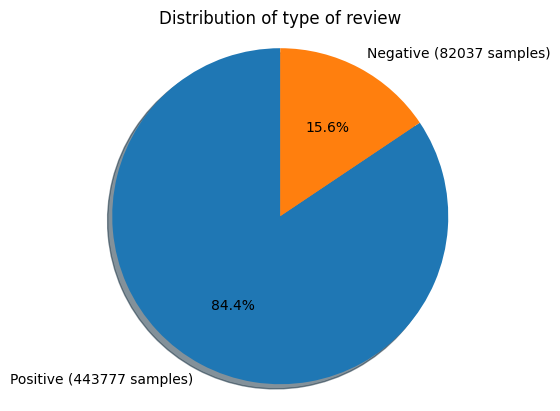

In [18]:
# counting the total positive and negative reviews
labels = [f'{k} ({foods_df["review/type"].value_counts()[k]} samples)' for k in foods_df['review/type'].value_counts().keys()]
sizes = dict(foods_df['review/type'].value_counts()).values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')
ax1.set_title("Distribution of type of review")
plt.show();

We can see that most of the reviews are positive. The postive reviews comprise almost 85% of the total data we have.

We can use word cloud to understand the frequently used words depending on the type of review

There are 185505236 words in the combination of all review.


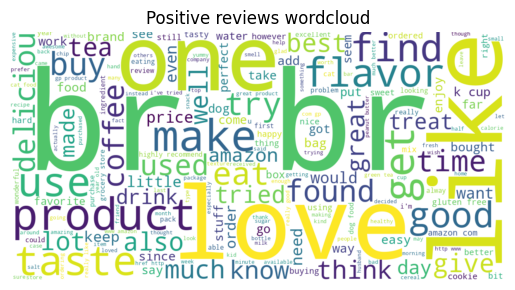

In [19]:
positive_review = foods_df[foods_df["review/type"] == "Positive"]
text = " ".join(review for review in positive_review['review/summary'] + positive_review['review/text'])
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
default_stopwords=set(stopwords.words('english'))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=default_stopwords, background_color="white", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure()
plt.title('Positive reviews wordcloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The words like like, delicious, great, good, best have appeared very frequently.
We can also see that there are lot of words that are not helpful for our classification. It has a lot of html tag related data that can be seen in the above word cloud. We can also infer that the number 1 has also very frequently occured in our data which has to be cleaned.

There are 38844364 words in the combination of all review.


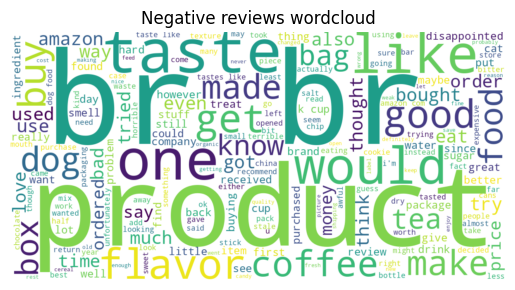

In [20]:
negative_review = foods_df[foods_df["review/type"] == "Negative"]
text = " ".join(review for review in negative_review['review/summary'] + negative_review['review/text'])
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
default_stopwords=set(stopwords.words('english'))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=default_stopwords, background_color="white", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure()
plt.title('Negative reviews wordcloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Words like bad, don't like can be seen
Similar to the postive review wordcloud we can observe the dominance of the html tag data that has to be cleaned.





We have to check if there was redundant data, the data that might have been duplicated. There are rows of data that have the same information.

In [21]:
# duplicate rows
mask_duplicated_reviews = foods_df.duplicated(subset=["review/userId","product/productId","review/time"], keep='first')
count_duplicated_reviews = mask_duplicated_reviews.value_counts()

sum_reviews = count_duplicated_reviews.sum()
perc_duplicated_reviews = (count_duplicated_reviews/sum_reviews) * 100
print(sum_reviews)
print(perc_duplicated_reviews)

525814
False    99.299182
True      0.700818
dtype: float64


In [22]:
# removing duplicate rows in a data frame
duplicate = foods_df[mask_duplicated_reviews]
duplicate.sort_values(by = ['review/profileName'])

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type
359571,B007M832YY,A3A1OA237FOZFK,#1 amazon fan,0/0,5.0,1296950400,love them & i'm a picky eater,"i was a little hesitant to try these, especial...",Positive
359572,B007M832YY,A3A1OA237FOZFK,#1 amazon fan,0/0,5.0,1296950400,from a picky eater - i love these,"i was a little hesitant to try these, especial...",Positive
30985,B007M83302,A3A1OA237FOZFK,#1 amazon fan,0/0,5.0,1296950400,from a picky eater - i love these,"i was a little hesitant to try these, especial...",Positive
30984,B007M83302,A3A1OA237FOZFK,#1 amazon fan,0/0,5.0,1296950400,love them & i'm a picky eater,"i was a little hesitant to try these, especial...",Positive
547610,B006HYLW32,A3A1OA237FOZFK,#1 amazon fan,0/0,5.0,1296950400,from a picky eater - i love these,"i was a little hesitant to try these, especial...",Positive
...,...,...,...,...,...,...,...,...,...
247331,B000EOXQS0,A1JLE30SBP6J3A,zefran,0/0,5.0,1308182400,lipton cup-a-soup - quick and easy,i like all the liption cup-a-soups. i have a k...,Positive
445314,B000ODH4BG,A1JLE30SBP6J3A,zefran,0/0,5.0,1308182400,lipton cup-a-soup - quick and easy,i like all the liption cup-a-soups. i have a k...,Positive
445315,B000ODH4BG,A1JLE30SBP6J3A,zefran,0/0,5.0,1308182400,lipton cup-a-soup,i like all the liption cup-a-soups. i have a k...,Positive
445313,B000ODH4BG,A1JLE30SBP6J3A,zefran,0/0,5.0,1308182400,lipton cup-a-soup - quick and easy,i like all the liption cup-a-soups. i have a k...,Positive


In [23]:
# delete the duplicate rows
foods_df = foods_df[~mask_duplicated_reviews]
foods_df

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,good quality dog food,i have bought several of the vitality canned d...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"natalia corres ""natalia corres""",1/1,4.0,1219017600,"""delight"" says it all",this is a confection that has been around a fe...,Positive
3,B000UA0QIQ,A395BORC6FGVXV,karl,3/3,2.0,1307923200,cough medicine,if you are looking for the secret ingredient i...,Negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"michael d. bigham ""m. wassir""",0/0,5.0,1350777600,great taffy,great taffy at a great price. there was a wid...,Positive
...,...,...,...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,lettie d. carter,0/0,5.0,1299628800,will not do without,great for sesame chicken..this is a good if no...,Positive
568450,B003S1WTCU,A3I8AFVPEE8KI5,r. sawyer,0/0,2.0,1331251200,disappointed,i'm disappointed with the flavor. the chocolat...,Negative
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2/2,5.0,1329782400,perfect for our maltipoo,"these stars are small, so you can give 10-15 o...",Positive
568452,B004I613EE,A3IBEVCTXKNOH,"kathy a. welch ""katwel""",1/1,5.0,1331596800,favorite training and reward treat,these are the best treats for training and rew...,Positive


In [24]:
# duplicate
mask_duplicated_reviews = foods_df.duplicated(subset=["review/userId","product/productId","review/summary"], keep='first')
count_duplicated_reviews = mask_duplicated_reviews.value_counts()

sum_reviews = count_duplicated_reviews.sum()
perc_duplicated_reviews = (count_duplicated_reviews/sum_reviews) * 100
print(sum_reviews)
print(perc_duplicated_reviews)

# removing duplicate rows in a data frame
duplicate = foods_df[mask_duplicated_reviews]
duplicate.sort_values(by = ['review/profileName'])

522129
False    99.950395
True      0.049605
dtype: float64


,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type
435906,B000LKXQCS,AWM1KZ2MDOVWJ,"a. winters ""be good humans.""",0/1,4.0,1193356800,great fake jerkey,this is a great substitute if you're vegetaria...,Positive
476555,B000LKVRVA,AWM1KZ2MDOVWJ,"a. winters ""be good humans.""",0/1,4.0,1193356800,great fake jerkey,this is a great substitute if you're vegetaria...,Positive
449431,B000LKZK36,AWM1KZ2MDOVWJ,"a. winters ""be good humans.""",0/1,4.0,1193356800,great fake jerkey,this is a great substitute if you're vegetaria...,Positive
412783,B000LKUAKY,AWM1KZ2MDOVWJ,"a. winters ""be good humans.""",0/1,4.0,1193356800,great fake jerkey,this is a great substitute if you're vegetaria...,Positive
72209,B000LKUAK4,AWM1KZ2MDOVWJ,"a. winters ""be good humans.""",0/1,4.0,1193356800,great fake jerkey,this is a great substitute if you're vegetaria...,Positive
...,...,...,...,...,...,...,...,...,...
353123,B000PMC7GI,AZYMD9P9F9UZ6,w. coombe,0/0,4.0,1238630400,good jerky,i like the peppered flavor a lot better than t...,Positive
88657,B000PMJLJO,AZYMD9P9F9UZ6,w. coombe,0/0,4.0,1238630400,good jerky,i like the peppered flavor a lot better than t...,Positive
35394,B000GW46D4,AZYMD9P9F9UZ6,w. coombe,0/0,4.0,1238630400,good jerky,i like the peppered flavor a lot better than t...,Positive
415856,B000GW6786,AZYMD9P9F9UZ6,w. coombe,0/0,4.0,1238630400,good jerky,i like the peppered flavor a lot better than t...,Positive


In [25]:
# delete the duplicate rows
foods_df = foods_df[~mask_duplicated_reviews]
foods_df

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,good quality dog food,i have bought several of the vitality canned d...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"natalia corres ""natalia corres""",1/1,4.0,1219017600,"""delight"" says it all",this is a confection that has been around a fe...,Positive
3,B000UA0QIQ,A395BORC6FGVXV,karl,3/3,2.0,1307923200,cough medicine,if you are looking for the secret ingredient i...,Negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"michael d. bigham ""m. wassir""",0/0,5.0,1350777600,great taffy,great taffy at a great price. there was a wid...,Positive
...,...,...,...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,lettie d. carter,0/0,5.0,1299628800,will not do without,great for sesame chicken..this is a good if no...,Positive
568450,B003S1WTCU,A3I8AFVPEE8KI5,r. sawyer,0/0,2.0,1331251200,disappointed,i'm disappointed with the flavor. the chocolat...,Negative
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2/2,5.0,1329782400,perfect for our maltipoo,"these stars are small, so you can give 10-15 o...",Positive
568452,B004I613EE,A3IBEVCTXKNOH,"kathy a. welch ""katwel""",1/1,5.0,1331596800,favorite training and reward treat,these are the best treats for training and rew...,Positive


In [26]:
# duplicate
mask_duplicated_reviews = foods_df.duplicated(subset=["review/userId","product/productId","review/text"], keep='first')
count_duplicated_reviews = mask_duplicated_reviews.value_counts()

sum_reviews = count_duplicated_reviews.sum()
perc_duplicated_reviews = (count_duplicated_reviews/sum_reviews) * 100
print(sum_reviews)
print(perc_duplicated_reviews)

# removing duplicate rows in a data frame
duplicate = foods_df[mask_duplicated_reviews]
duplicate.sort_values(by = ['review/profileName'])

521870
False    99.990994
True      0.009006
dtype: float64


,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type
488254,B0013A0QXC,A3K5C7JVGRD7EM,"b. van gelder ""senseo""",0/0,5.0,1278288000,price review urgently needed again,"excellent product, fast delivery, excellent pr...",Positive
464614,B000UBD88A,A3K5C7JVGRD7EM,"b. van gelder ""senseo""",0/0,5.0,1278288000,price review urgently needed again,"excellent product, fast delivery, excellent pr...",Positive
126174,B000XQ5HDQ,A21Z8B8XSZ4R17,eric r. dierks,0/1,5.0,1226793600,"jack link's x-sticks 30-pack, original","this stuff is great for snacking, has a long s...",Positive
463539,B000GW67KY,A21Z8B8XSZ4R17,eric r. dierks,0/1,5.0,1226793600,"jack link's x-sticks 30-pack, original","this stuff is great for snacking, has a long s...",Positive
302871,B000GW0UGG,A21Z8B8XSZ4R17,eric r. dierks,0/1,5.0,1226793600,"jack link's x-sticks 30-pack, original","this stuff is great for snacking, has a long s...",Positive
10884,B0034KP00S,A1TMAVN4CEM8U8,gunner,0/1,5.0,1336348800,i prefer the flavored,diamond almonds<br />almonds are a good source...,Positive
562165,B004HOSGWE,A1TMAVN4CEM8U8,gunner,0/0,5.0,1334880000,my 9th favorite flavor.,diamond almonds<br />almonds are a good source...,Positive
225034,B001LNTY70,A1TMAVN4CEM8U8,gunner,0/0,5.0,1334880000,my 9th favorite flavor.,diamond almonds<br />almonds are a good source...,Positive
229970,B000ZSX4GE,A1TMAVN4CEM8U8,gunner,0/1,5.0,1336348800,i prefer the flavored,diamond almonds<br />almonds are a good source...,Positive
307041,B004HOOZEW,A1TMAVN4CEM8U8,gunner,0/0,5.0,1335398400,my 4th favorite flavor,diamond almonds<br />almonds are a good source...,Positive


As we observed in the word cloud there is a lot of data with the html tags. So, using beautiful soup we are deleting the data that includes words like br, .com

In [27]:
# Function to remove HTML tags from a string
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()
     # Replace <br> tags with spaces
    for br in soup.find_all('br'):
        br.replace_with(' ')

    return soup.get_text()

foods_df['review/text'] = foods_df['review/text'].apply(remove_html_tags)
foods_df['review/summary'] = foods_df['review/summary'].apply(remove_html_tags)
foods_df

<ipython-input-27-2164b4b2f235>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
<ipython-input-27-2164b4b2f235>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df['review/text'] = foods_df['review/text'].apply(remove_html_tags)
<ipython-input-27-2164b4b2f235>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
<ipython-input-27-2164b4b2f235>:12: SettingWithCopyWarning: 
A value is trying to 

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,good quality dog food,i have bought several of the vitality canned d...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"natalia corres ""natalia corres""",1/1,4.0,1219017600,"""delight"" says it all",this is a confection that has been around a fe...,Positive
3,B000UA0QIQ,A395BORC6FGVXV,karl,3/3,2.0,1307923200,cough medicine,if you are looking for the secret ingredient i...,Negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"michael d. bigham ""m. wassir""",0/0,5.0,1350777600,great taffy,great taffy at a great price. there was a wid...,Positive
...,...,...,...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,lettie d. carter,0/0,5.0,1299628800,will not do without,great for sesame chicken..this is a good if no...,Positive
568450,B003S1WTCU,A3I8AFVPEE8KI5,r. sawyer,0/0,2.0,1331251200,disappointed,i'm disappointed with the flavor. the chocolat...,Negative
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2/2,5.0,1329782400,perfect for our maltipoo,"these stars are small, so you can give 10-15 o...",Positive
568452,B004I613EE,A3IBEVCTXKNOH,"kathy a. welch ""katwel""",1/1,5.0,1331596800,favorite training and reward treat,these are the best treats for training and rew...,Positive


There are a lot of times when humans express emotions with a lot of charaters where not necessary like soooo goooddd. We are trying to eliminate those characters by deleting the characters which have the same repeated character for more than 3 times.

In [28]:
# removing words with repeated alphabets
def remove_words_with_repeated_characters(sentence):
    pattern = re.compile("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b")
    clean_text  = re.sub(pattern,' ',sentence)
    return (clean_text)


# apply the function:
foods_df['review/summary'] = foods_df['review/summary'].apply(remove_words_with_repeated_characters)
foods_df['review/text'] = foods_df['review/text'].apply(remove_words_with_repeated_characters)
foods_df.head()

<ipython-input-28-0c3f8c00e636>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df['review/summary'] = foods_df['review/summary'].apply(remove_words_with_repeated_characters)
<ipython-input-28-0c3f8c00e636>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df['review/text'] = foods_df['review/text'].apply(remove_words_with_repeated_characters)


,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,good quality dog food,i have bought several of the vitality canned d...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"natalia corres ""natalia corres""",1/1,4.0,1219017600,"""delight"" says it all",this is a confection that has been around a fe...,Positive
3,B000UA0QIQ,A395BORC6FGVXV,karl,3/3,2.0,1307923200,cough medicine,if you are looking for the secret ingredient i...,Negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"michael d. bigham ""m. wassir""",0/0,5.0,1350777600,great taffy,great taffy at a great price. there was a wid...,Positive


We observed in our word cloud that the numebr 1 was repeated a lot of times. There might be a lot of numerical data in the text columns like that which are noise for us. So, we are cleaning numerical data.

In [29]:
# removing digits
def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
    return re.sub(pattern, '', text)

# apply the function:
foods_df['review/summary'] = foods_df['review/summary'].apply(remove_digits)
foods_df['review/text'] = foods_df['review/text'].apply(remove_digits)
foods_df.head()

<ipython-input-29-d1eabc9a2ba0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df['review/summary'] = foods_df['review/summary'].apply(remove_digits)
<ipython-input-29-d1eabc9a2ba0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df['review/text'] = foods_df['review/text'].apply(remove_digits)


,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,good quality dog food,i have bought several of the vitality canned d...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"natalia corres ""natalia corres""",1/1,4.0,1219017600,"""delight"" says it all",this is a confection that has been around a fe...,Positive
3,B000UA0QIQ,A395BORC6FGVXV,karl,3/3,2.0,1307923200,cough medicine,if you are looking for the secret ingredient i...,Negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"michael d. bigham ""m. wassir""",0/0,5.0,1350777600,great taffy,great taffy at a great price. there was a wid...,Positive


While classifying data having punctutaions and special charcters just increases the amount of data but not useful data.

In [30]:
# create function for punctuation and special characters removal:
def remove_special_chars_punctuations(sentence):
    # match a single character not present in the set (basically anything other than a-z and A-Z)
    pattern = re.compile("[^a-zA-Z]+")
    clean_text  = re.sub(pattern,' ',sentence).strip()
    return clean_text

# apply the function:
foods_df['review/summary'] = foods_df['review/summary'].apply(remove_special_chars_punctuations)
foods_df['review/text'] = foods_df['review/text'].apply(remove_special_chars_punctuations)
foods_df.head()

<ipython-input-30-24e128c81ff2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df['review/summary'] = foods_df['review/summary'].apply(remove_special_chars_punctuations)
<ipython-input-30-24e128c81ff2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df['review/text'] = foods_df['review/text'].apply(remove_special_chars_punctuations)


,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,good quality dog food,i have bought several of the vitality canned d...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"natalia corres ""natalia corres""",1/1,4.0,1219017600,delight says it all,this is a confection that has been around a fe...,Positive
3,B000UA0QIQ,A395BORC6FGVXV,karl,3/3,2.0,1307923200,cough medicine,if you are looking for the secret ingredient i...,Negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"michael d. bigham ""m. wassir""",0/0,5.0,1350777600,great taffy,great taffy at a great price there was a wide ...,Positive


STOP words are a major thing than can be eliminated while cleaning text data. Stop words are a set of commomly used word in a language. These words include 'a', 'the', 'is', 'are' etc. These words usually have a very little almost no importance in our classification. Eliminating these words will give us only the useful words in a big sentence which will help us better classify.

In [31]:
# cleaning the stop words
stop_words = set(stopwords.words('english'))
foods_df['review/text'] = foods_df['review/text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
foods_df['review/summary'] = foods_df['review/summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
foods_df

<ipython-input-31-bf2535701b8d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df['review/text'] = foods_df['review/text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
<ipython-input-31-bf2535701b8d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df['review/summary'] = foods_df['review/summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,good quality dog food,bought several vitality canned dog food produc...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,advertised,product arrived labeled jumbo salted peanuts p...,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"natalia corres ""natalia corres""",1/1,4.0,1219017600,delight says,confection around centuries light pillowy citr...,Positive
3,B000UA0QIQ,A395BORC6FGVXV,karl,3/3,2.0,1307923200,cough medicine,looking secret ingredient robitussin believe f...,Negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"michael d. bigham ""m. wassir""",0/0,5.0,1350777600,great taffy,great taffy great price wide assortment yummy ...,Positive
...,...,...,...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,lettie d. carter,0/0,5.0,1299628800,without,great sesame chicken good better resturants ea...,Positive
568450,B003S1WTCU,A3I8AFVPEE8KI5,r. sawyer,0/0,2.0,1331251200,disappointed,disappointed flavor chocolate notes especially...,Negative
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2/2,5.0,1329782400,perfect maltipoo,stars small give one training session tried tr...,Positive
568452,B004I613EE,A3IBEVCTXKNOH,"kathy a. welch ""katwel""",1/1,5.0,1331596800,favorite training reward treat,best treats training rewarding dog good groomi...,Positive


We are plotting the word cloud after cleaning the data to see how well we were able to clean the data.

There are 111719718 words in the combination of all review.


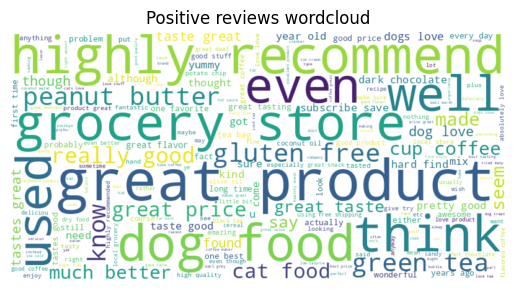

In [32]:
positive_review = foods_df[foods_df["review/type"] == "Positive"]
text = " ".join(review for review in positive_review['review/text'] + ' ' + positive_review['review/summary'])
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
default_stopwords=set(stopwords.words('english'))

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image:
plt.figure()
plt.title('Positive reviews wordcloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

After cleaning the data and removing the unnecessary data we can see that our word cloud has words that are relavent to the positive feedback. We can see that the html data and numerical data that was present in the plot before is eliminated.

There are 22594232 words in the combination of all review.


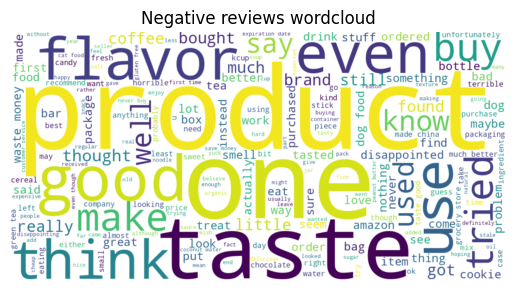

In [33]:
negative_review = foods_df[foods_df["review/type"] == "Negative"]
text = " ".join(review for review in negative_review['review/text'] + ' ' + negative_review['review/summary'])
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
default_stopwords=set(stopwords.words('english'))

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure()
plt.title('Negative reviews wordcloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [34]:
# downloading the needed resources
# Download necessary resources
nltk.download('punkt')
nltk.download('wordnet')

# lemmatizing the data
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

foods_df['lemmatized_text'] = foods_df['review/text'].apply(lemmatize_text)
foods_df['lemmatized_summary'] = foods_df['review/summary'].apply(lemmatize_text)

# after lemmatizing
foods_df.head(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-34-0314e85d9ffa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df['lemmatized_text'] = foods_df['review/text'].apply(lemmatize_text)
<ipython-input-34-0314e85d9ffa>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df['lemmatized_summary'] = foods_df['review/s

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type,lemmatized_text,lemmatized_summary
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,good quality dog food,bought several vitality canned dog food produc...,Positive,bought several vitality canned dog food produc...,good quality dog food
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,advertised,product arrived labeled jumbo salted peanuts p...,Negative,product arrived labeled jumbo salted peanut pe...,advertised
2,B000LQOCH0,ABXLMWJIXXAIN,"natalia corres ""natalia corres""",1/1,4.0,1219017600,delight says,confection around centuries light pillowy citr...,Positive,confection around century light pillowy citrus...,delight say
3,B000UA0QIQ,A395BORC6FGVXV,karl,3/3,2.0,1307923200,cough medicine,looking secret ingredient robitussin believe f...,Negative,looking secret ingredient robitussin believe f...,cough medicine
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"michael d. bigham ""m. wassir""",0/0,5.0,1350777600,great taffy,great taffy great price wide assortment yummy ...,Positive,great taffy great price wide assortment yummy ...,great taffy
5,B006K2ZZ7K,ADT0SRK1MGOEU,twoapennything,0/0,4.0,1342051200,nice taffy,got wild hair taffy ordered five pound bag taf...,Positive,got wild hair taffy ordered five pound bag taf...,nice taffy
6,B006K2ZZ7K,A1SP2KVKFXXRU1,david c. sullivan,0/0,5.0,1340150400,great good expensive brands,saltwater taffy great flavors soft chewy candy...,Positive,saltwater taffy great flavor soft chewy candy ...,great good expensive brand
7,B006K2ZZ7K,A3JRGQVEQN31IQ,pamela g. williams,0/0,5.0,1336003200,wonderful tasty taffy,taffy good soft chewy flavors amazing would de...,Positive,taffy good soft chewy flavor amazing would def...,wonderful tasty taffy
8,B000E7L2R4,A1MZYO9TZK0BBI,r. james,1/1,5.0,1322006400,yay barley,right mostly sprouting cats eat grass love rot...,Positive,right mostly sprouting cat eat grass love rota...,yay barley
9,B00171APVA,A21BT40VZCCYT4,carol a. reed,0/0,5.0,1351209600,healthy dog food,healthy dog food good digestion also good smal...,Positive,healthy dog food good digestion also good smal...,healthy dog food


In [35]:
# making a new column
foods_df['clean_combined_text'] = foods_df['lemmatized_summary'] + ' ' + foods_df['lemmatized_text']
foods_df.head()

<ipython-input-35-10ad7eefa6ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foods_df['clean_combined_text'] = foods_df['lemmatized_summary'] + ' ' + foods_df['lemmatized_text']


,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/type,lemmatized_text,lemmatized_summary,clean_combined_text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,good quality dog food,bought several vitality canned dog food produc...,Positive,bought several vitality canned dog food produc...,good quality dog food,good quality dog food bought several vitality ...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,advertised,product arrived labeled jumbo salted peanuts p...,Negative,product arrived labeled jumbo salted peanut pe...,advertised,advertised product arrived labeled jumbo salte...
2,B000LQOCH0,ABXLMWJIXXAIN,"natalia corres ""natalia corres""",1/1,4.0,1219017600,delight says,confection around centuries light pillowy citr...,Positive,confection around century light pillowy citrus...,delight say,delight say confection around century light pi...
3,B000UA0QIQ,A395BORC6FGVXV,karl,3/3,2.0,1307923200,cough medicine,looking secret ingredient robitussin believe f...,Negative,looking secret ingredient robitussin believe f...,cough medicine,cough medicine looking secret ingredient robit...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"michael d. bigham ""m. wassir""",0/0,5.0,1350777600,great taffy,great taffy great price wide assortment yummy ...,Positive,great taffy great price wide assortment yummy ...,great taffy,great taffy great taffy great price wide assor...


In [36]:
# Splitting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(foods_df['clean_combined_text'], foods_df['review/score'], test_size=0.2, random_state=42)

In [37]:
# Vectorizing the text
# Bags of words
vectorizer = CountVectorizer()

X_train_text = vectorizer.fit_transform(X_train)
X_test_text = vectorizer.transform(X_test)

Naive Bayes classifier

In [38]:
# creating a naive bayes classifier
classifier = MultinomialNB(force_alpha=True)

# fit the data to the classifier
classifier.fit(X_train_text, y_train)

MultinomialNB(force_alpha=True)

In [39]:
# Evaluating the model
y_prediction = classifier.predict(X_test_text)

# accuracy
accuracy = accuracy_score(y_test, y_prediction)
print("Accuracy", accuracy)

Accuracy 0.7713127790445896


Logistic regression

In [40]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train_text, y_train)

y_pred = classifier.predict(X_test_text)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
# print(classification_report(y_test, y_pred))

Accuracy: 0.8196294096230862


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


To classify the score using reviews we have to first clean the data to ensure that we give our classifier clean data to make sure we build a good model.

After reading the data into a pandas Data Frame we are cleaning the data. These are the ways the data has been cleaned.
1. We made all the data into lower case to ensure that data is read similarly.
2. We removed duplicate rows of data to ensure there is no redundant data.
3. HTML tags data is being as deleted as the given data has been scraped from a website and contains a lot of html tag data.
4. There was a lot of data where one character has been repeated more than once to express emotions those type of data has been cleaned.
5. Removed punctuations and special cravings to eliminate excess data that has no importance for our classification.
6. Removed digits from textual data.
7. STOP words take up a lot of space that is not required. English words that are used to make sentences gramatically correct. These words are not needed for our classification.

Before and after cleaning the data a word cloud is plotted to see the freqency of the words in our data. We can see the clear distinction of the data difference between the wordclouds that are plotted.

Naive Bayes and logistic regression have been used to classify the data. We can see that logistic regression predicted the data more accurately than naive bayes.

Accuracy of Naive Bayes: 77.13%

Accuracy of logistic regression: 81.96%